## Projet statistiques avancés - DU 

In [1]:
# DU Advanced Statistics project 2021
# date : 17/11/2021
# Author : Sania TERKI

In [89]:
# library importation
import pandas as pd
import numpy as np 
import math 
import scipy.optimize 
import scipy.stats as stats
import pylab
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from matplotlib.patches import Ellipse
from math import pi

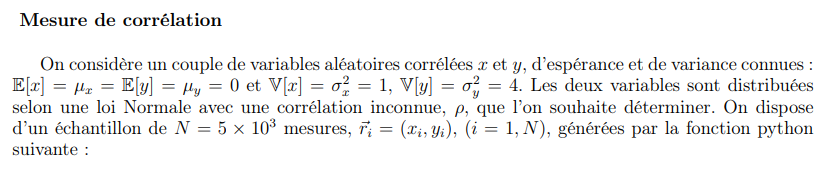

In [71]:
def data(N=5000) :
    np.random.seed(154) # for reproducibility
    M=[0.,0.] # known expected values : E[x] = E[y] = 0
    Vx,Vy=1.0,4.0 # known variances : Var(x)=1 ; Var(y)=4
    r=np.random.uniform(0,1) # ’unknown’ correlation (KEEP IT BLIND - DO NOT PRINTOUT)
    Cxy=r * math.sqrt(Vx*Vy) # Covariance(x,y)
    COV =[ [ Vx , Cxy ], [Cxy, Vy ] ] # Covariance matrix
    XY=np.random.multivariate_normal(M, COV, size=N) # data generator XY = {(x_i,y_i)}
    return XY

In [72]:
data()

array([[ 1.69670676,  2.63758547],
       [ 0.97681916,  0.87181651],
       [ 0.89727048,  2.07568048],
       ...,
       [-0.82187748, -2.51671312],
       [ 0.37899759,  2.21654908],
       [-0.9428099 , -0.42198529]])

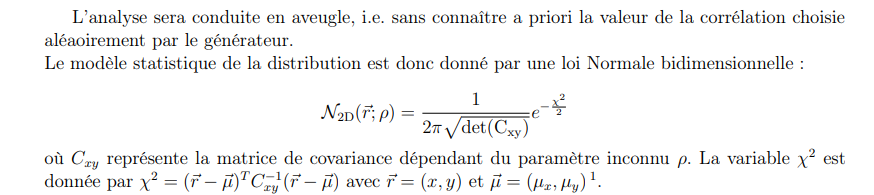

### En déduire - et implémenter en python - l’expression du log-likelihood négatif, −logL(ρ)

In [73]:
r = data(N=5000)

def log_likelihood(gho, r):
    ksi2 = 1/(1-gho**2) * (((1/1)*r[:,0]**2) + ((1/4)*r[:,1]**2) + ((-(2*gho)/(np.sqrt(4*1))) * (r[:,1] * r[:,0])))
    return np.sum((1/2 * (np.log(1-gho**2) + ksi2)))

In [74]:
log_likelihood(0.5,r)

4199.741577818852

### En utilisant les outils de minimisation du module scipy, déterminer la valeur ρˆ qui minimise −logL(ρ) ainsi que la valeur minimale correspondante, (−logL)min = −logL(ˆρ)

In [75]:
mini = scipy.optimize.minimize(log_likelihood, 0.1 ,args = r, method = 'Nelder-Mead')
mini

 final_simplex: (array([[0.51304688],
       [0.513125  ]]), array([4198.78559983, 4198.78560898]))
           fun: 4198.785599827454
       message: 'Optimization terminated successfully.'
          nfev: 36
           nit: 18
        status: 0
       success: True
             x: array([0.51304688])

In [76]:
estimate_logL_gho = mini.fun
min_gho = mini.x[0]
min_gho

0.5130468750000015

In [77]:
Gho=np.linspace(-0.9,0.9,1000)

In [78]:
#define function that compute the delta loglikelihood
def delta_log(var):
    delta_log=[]
    for v in var :
        x = -estimate_logL_gho + log_likelihood(v,r)
        delta_log.append(x)
    return delta_log

### Tracer la fonction ∆logL(ρ) = logL(ˆρ) − logL(ρ)

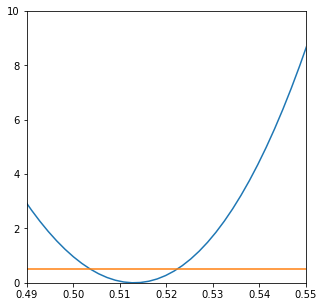

In [79]:
delta_log(Gho)

plt.figure(figsize=(5,5))
plt.plot(Gho,delta_log(Gho))
plt.xlim([0.49, 0.55])
plt.ylim([0, 10])

def line(var,x0):
    return np.full_like(var,x0)

plt.plot(Gho,line(Gho,1/2));

In [80]:
# determine the 2 values
inter = np.argwhere(np.diff(np.sign(delta_log(Gho) - line(Gho,1/2)))).flatten()
values = Gho[inter]
print("The first intersection value is", values[0], "\n The second intersection value is", values[1] )
sigma = np.abs((values[0]-values[1]))/2
print("The sigma value is", sigma)

The first intersection value is 0.5036036036036037 
 The second intersection value is 0.5216216216216215
The sigma value is 0.009009009009008917


### Donner une représentation graphique bidimensionnelle des mesures (xi, yi). Tracer sur la même figure l’ellipse de χ2 constant correspondant à χ2 = α90 = Qχ2 (p = 90%, ndof = 2), où Qχ2 (p, ndof) est la fonction de répartition inverse (i.e. fonction quantile) de la loi de χ2 à ndof degrés de liberté. L’orientation de l’ellipse sera calculée en utilisant la valeur estimée ρˆ.

In [81]:
Cxy = min_gho * math.sqrt(1*4) #  math.sqrt( Vx * Vy )
Cov = [[ 1.0 , Cxy ],[Cxy, 4.0 ]]
print(Cov)

[[1.0, 1.026093750000003], [1.026093750000003, 4.0]]


In [82]:
w, v = np.linalg.eig(Cov) # compute the eigen values to draw the ellipse
a, b = np.sqrt(w)

In [83]:
angle = (0.5 * np.arctan((2 * min_gho * 2)/(1-4))) * (180/np.pi)
print("The value of the angle is", angle)
s = 4.605

The value of the angle is -17.187283725659377


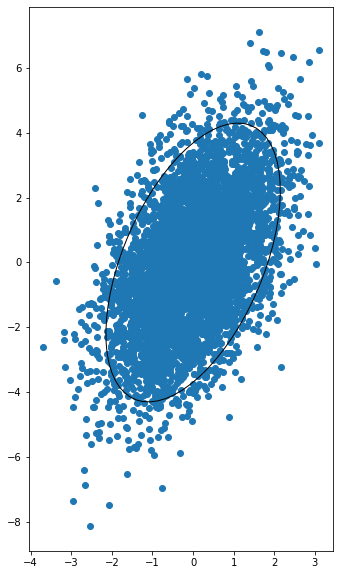

In [84]:
#Draw the plot
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(121)
ax.scatter(r[:,0], r[:,1])

Elps = Ellipse([0,0],2 * a * np.sqrt(s),2 * b * np.sqrt(s), angle, facecolor="None", edgecolor='black')
ax.add_patch(Elps)

plt.show()

### Etude de coverage - en déduire la fraction pˆ90 = N90/N et déterminer l’incertitude statistique associée, (σpˆ90 )stat, en utilisant la loi binomiale.


In [101]:
s = stats.chi2.ppf(0.9, df= 2) #determining percentile point function
S = np.full((5000,), s)
angle_rad = angle * np.pi/180 #convert the angle in radian

#compute the rotation of matrix
Rot_mat=[ [ np.cos(angle_rad) , np.sin(angle_rad) ], [-np.sin(angle_rad), np.cos(angle_rad) ]] 
rot=[]

for i in range(5000):
    rot.append(np.dot(Rot_mat, r[i,:]))
rot = np.array(rot)

# compute (σpˆ90)st
elps = (rot[:,0] / a)**2 + (rot[:,1] / b)**2
filt = (elps <= S) 
port = filt.sum() / 5000 #compute the portion
p_errstat = np.sqrt(port * (1-port) / 5000)
print("L’incertitude statistique associé (σpˆ90 )st est de", p_errstat)

L’incertitude statistique associé (σpˆ90 )st est de 0.004227513690102019


### Déterminer l’erreur systématique (δpˆ90 )syst induite par l’incertitude σρˆ affectant le paramètre de corrélation ρ

In [107]:
arr_gho = [min_gho - sigma, min_gho, min_gho + sigma]
flt_list=[]

for gho in arr_gho:     
    Cxy = gho*math.sqrt(1*4) 
    Cov = [[ 1, Cxy ], [Cxy, 4 ]]
    w,v = np.linalg.eig(Cov)
    a,b = np.sqrt(w)
    
    angle_rad = (0.5 * np.arctan((2 * gho * 2) / (1-4)))
    
    # compute the rotation of matrix
    Rot_mat=[[ np.cos(angle_rad), np.sin(angle_rad)], [-np.sin(angle_rad), np.cos(angle_rad) ]] 
    rot=[]
    
    for i in range(5000):
        rot.append(np.dot(Rot_mat, r[i,:]))
    rot = np.array(rot)
    S = np.full((5000,), s) 
    
    elps = (rot[:,0] / a)**2 + (rot[:,1] / b)**2
    filt = (elps<=S)
    port = filt.sum() / 5000
    flt_list.append(port)
    
error_sys=np.array(flt_list).std()
print("L'erreur systématique est de", error_sys)
ratio = p_errstat/error_sys
print("L'erreur systématique est négligeable car le ratio est de", ratio)

L'erreur systématique est de 0.0006798692684790501
L'erreur systématique est négligeable car le ratio est de 6.218127346099169


### Répéter la détermination de pˆcl et de son erreur statistique (σpˆcl )stat. pour différentes ellipses correspondant à des valeurs de cl variant de 0.5% à 99.5% par pas de 3%